<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [4]:
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import multistock

from utils import *
from indicators import *
from dataset import Dataset
from forecaster import Forecaster
from solver import Solver
from os.path import join, isfile
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from pandas_datareader import data as pdr
import yfinance as yf

yf.pdr_override()
%matplotlib inline

[*********************100%***********************]  5 of 5 completed


/Users/achar/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


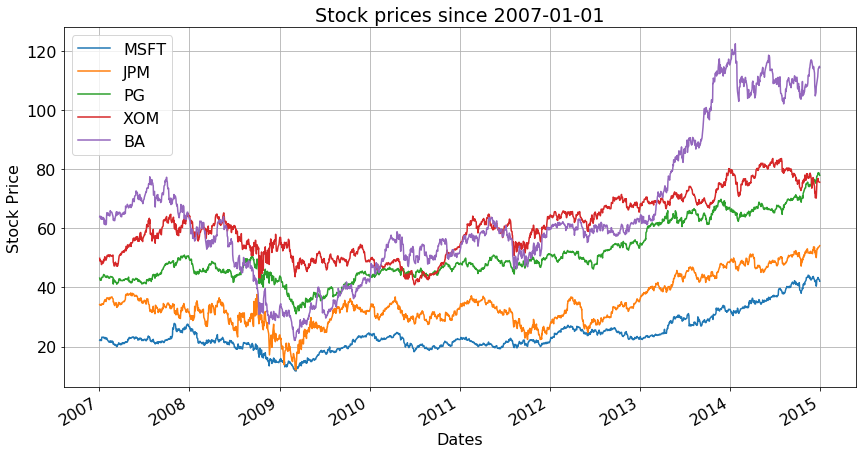

In [2]:
tickers = ['MSFT', 'JPM', 'PG', 'XOM', 'BA']
startdate = "2007-01-01"
enddate = "2014-12-31"

df_prices = pdr.get_data_yahoo(tickers, 
                               start=startdate, 
                               end=enddate,
                               groupby='ticker')

plt.rcParams['font.size'] = 16
fig = plt.figure(figsize=(11, 5))
ax = fig.add_axes([0, 0, 1, 1])
for tick in tickers:
    df_prices['Adj Close'][tick].plot(y=tick, ax=ax)

ax.set_xlabel('Dates')
ax.set_ylabel('Stock Price')
ax.set_title('Stock prices since ' + startdate)
ax.legend()
fig.autofmt_xdate(rotation=30)
ax.grid()
plt.tight_layout()
plt.savefig('imgs/stock_prices_07to014.png')
plt.show()

In [11]:
n_columns = 5
headline_files = [
    'data/Headlines_MicroSoft.csv',
    'data/Headlines_JPMorgan.csv',
    'data/Headlines_P&G.csv',
    'data/Headlines_Exxon.csv',
    'data/Headlines_Boeing.csv'
]


stock_sentiments = {}
# Read all csv files as data frames
for i, filename in enumerate(headline_files):
    df_news = pd.read_csv(filename)
    df_news = df_news.set_index(pd.to_datetime(df_news['Time']))
    df_news.drop(['Time'], inplace=True, axis=1)
    df_news.fillna(value='', inplace=True)
    
    cols = np.arange(1,n_columns+1)
    df_news = df_news[df_news.columns[cols]]
    scores = headlineScores(df_news)

    # Calculate sentiment average
    scores_avg = scores.mean(axis=1)
    scores_avg.rename('avg', inplace=True)

    # Calculate sentiment direction
    scores_dir = scores.sum(axis=1)
    scores_dir[scores_dir > 0] = 1
    scores_dir[scores_dir < 0] = -1
    scores_dir.rename('dir', inplace=True)
    
    df_dummy = pd.DataFrame(
        index=df_prices['Adj Close'][tickers[0]].index)
    df_sentiment = pd.concat([scores_avg, scores_dir], axis=1)
    sentiment = df_dummy.join(df_sentiment)[['avg', 'dir']].to_numpy()
    sentiment = np.nan_to_num(sentiment) # Turns NaN's to numbers
    stock_sentiments[tickers[i]] = sentiment

In [28]:
batch_size = 14
seq_length = 10
test_size = 0.25
predict_ahead = 7
test_size=0.2

USE_HEADLINES = True

# test_type = 'all_stocks'
test_type = 'new_stocks'

technical_indicators = [
    sma,  # Simple Moving Average
    wma,  # Weighted Moving Average
    mom,  # Exponential Moving Average
    macd,  # Moving Average Convergence Divergence
    rsi,  # Relative Strength Indicator
    stoch,  # Stochastic %K and %D
    willr,  # Larry Williams %R
    adosc,  # Accumulation / Distribution Oscillator
#     arima_sma,  # ARIMA on a SMA
#     arima_wma,  # ARIMA on a WMA 
#     arima_ema,  # ARIMA on an EMA
]

# Load parameter file
with open('params/stocks.yaml') as file:
    params = yaml.full_load(file)

multi_features, mulit_labels, selectrows = multistock.cleanData(
    df_prices, technical_indicators, params, predict=predict_ahead)

if USE_HEADLINES:
    for tick in multi_features.keys():
        multi_features[tick] = np.concatenate(
            (multi_features[tick], 
             stock_sentiments[tick][selectrows]), axis=1)
    
tick = next(iter(multi_features))
n_features = multi_features[tick].shape[1]

features = np.empty(shape=(0, n_features))
for tick in multi_features.keys():
    features = np.concatenate((features, multi_features[tick]))

scaler = StandardScaler()
scaler = scaler.fit(features)

result = multistock.train_test_split(multi_features, mulit_labels, scaler,
                                     seq_length, n_features=n_features, 
                                     test_type=test_type, test_size=test_size)

X_train, X_test, y_train, y_test = result

print('X Train Shape: ', X_train.shape)
print('X Test Shape: ', X_test.shape)
print('Y Train Shape: ', y_train.shape)
print('Y Test Shape: ', y_test.shape)

data_sets = {
    'train': Dataset(X_train, y_train),
    'val': Dataset(X_test, y_test)
}
dataloaders = {
    'train': DataLoader(data_sets['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(data_sets['val'], batch_size=1, shuffle=False)
}
dataset_sizes = {x: len(data_sets[x]) for x in ['train', 'val']}

baseline = np.ones_like(y_test)
accuracy = accuracy_score(y_test, baseline)
print(f'Average Baseline Accuracy: {accuracy * 100:.2f}%')

Creating features for BA
Removing 40 rows from data
Creating features for JPM
Removing 40 rows from data
Creating features for MSFT
Removing 40 rows from data
Creating features for PG
Removing 40 rows from data
Creating features for XOM
Removing 40 rows from data
Using XOM data for testing
X Train Shape:  (7856, 10, 12)
X Test Shape:  (1964, 10, 12)
Y Train Shape:  (7856, 1)
Y Test Shape:  (1964, 1)
Average Baseline Accuracy: 56.01%


In [29]:
modelparams = {}
modelparams['n_features'] = features.shape[1]
modelparams['n_hidden'] = 8
modelparams['n_layers'] = 2
modelparams['dropout'] = 0.8

solverparams = {}
solverparams['num_epochs'] = 20
solverparams['verbose'] = True
solverparams['plot'] = False

iters=10
threshold=0.5

results = calcMetrics(modelparams, solverparams, dataloaders,
                      dataset_sizes, iters=iters, threshold=threshold)
accuracy, precision, recall = results

print('LSTM Model: Accuracy=%.3f' % accuracy)
print('LSTM Model: Precision=%.3f' % precision)
print('LSTM Model: Recall=%.3f' % recall)

Model Evaluation #1
Using cpu for training.
Epoch: 1-train Loss: 0.6885 Acc: 0.5508
Epoch: 1-val Loss: 0.6850 Acc: 0.5601
Epoch: 2-train Loss: 0.6871 Acc: 0.5556
Epoch: 2-val Loss: 0.6841 Acc: 0.5601
Epoch: 3-train Loss: 0.6864 Acc: 0.5547
Epoch: 3-val Loss: 0.6842 Acc: 0.5601
Epoch: 4-train Loss: 0.6862 Acc: 0.5549
Epoch: 4-val Loss: 0.6846 Acc: 0.5601
Epoch: 5-train Loss: 0.6850 Acc: 0.5575
Epoch: 5-val Loss: 0.6857 Acc: 0.5433
Early stop activated @ epoch: 4
Training complete in 0m 34s
Best val acc: 0.560081
Model Evaluation #2
Using cpu for training.
Epoch: 1-train Loss: 0.6872 Acc: 0.5544
Epoch: 1-val Loss: 0.6856 Acc: 0.5601
Epoch: 2-train Loss: 0.6868 Acc: 0.5540
Epoch: 2-val Loss: 0.6860 Acc: 0.5601
Epoch: 3-train Loss: 0.6858 Acc: 0.5536
Epoch: 3-val Loss: 0.6860 Acc: 0.5540
Epoch: 4-train Loss: 0.6855 Acc: 0.5594
Epoch: 4-val Loss: 0.6868 Acc: 0.5504
Epoch: 5-train Loss: 0.6844 Acc: 0.5601
Epoch: 5-val Loss: 0.6882 Acc: 0.5178
Epoch: 6-train Loss: 0.6833 Acc: 0.5654
Epoch: 6-

Epoch: 7-train Loss: 0.6862 Acc: 0.5544
Epoch: 7-val Loss: 0.6852 Acc: 0.5601
Epoch: 8-train Loss: 0.6858 Acc: 0.5564
Epoch: 8-val Loss: 0.6857 Acc: 0.5300
Epoch: 9-train Loss: 0.6854 Acc: 0.5563
Epoch: 9-val Loss: 0.6875 Acc: 0.5224
Epoch: 10-train Loss: 0.6850 Acc: 0.5575
Epoch: 10-val Loss: 0.6894 Acc: 0.5249
Early stop activated @ epoch: 9
Training complete in 1m 11s
Best val acc: 0.560081
LSTM Model: Accuracy=0.559
LSTM Model: Precision=0.562
LSTM Model: Recall=0.971


In [31]:
print('LSTM Model: Precision=%.3f' % (precision*100))
print('LSTM Model: Recall=%.3f' % (recall*100))
print('LSTM Model: Accuracy=%.3f' % (accuracy*100))

LSTM Model: Precision=56.198
LSTM Model: Recall=97.055
LSTM Model: Accuracy=55.886


In [30]:
ns_pred = np.ones_like(y_test)

ns_classifications = classify(ns_pred, threshold=0.5)
ns_accuracy = accuracy_score(y_test, ns_classifications)
ns_precision = precision_score(y_test, ns_classifications)
ns_recall = recall_score(y_test, ns_classifications)

print('No Skill: Precision=%.3f' % (ns_precision * 100))
print('No Skill: Recall=%.3f' % (ns_recall * 100))
print('No Skill: Accuracy=%.3f' % (ns_accuracy * 100))

No Skill: Precision=56.008
No Skill: Recall=100.000
No Skill: Accuracy=56.008
